In [10]:
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import sys
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import os
import random

In [11]:
class Dinov2Matcher:
    def __init__(self, repo_name="facebookresearch/dinov2", model_name="dinov2_vitb14", smaller_edge_size=448, half_precision=False, device="cuda"):
        self.repo_name = repo_name
        self.model_name = model_name
        self.smaller_edge_size = smaller_edge_size
        self.half_precision = half_precision
        self.device = device

        if self.half_precision:
            self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).half().to(self.device)
        else:
            self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).to(self.device)

        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize(size=smaller_edge_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet defaults
        ])

    def prepare_image(self, rgb_image_numpy):
        image = Image.fromarray(rgb_image_numpy)
        image_tensor = self.transform(image)
        resize_scale = image.width / image_tensor.shape[2]

        height, width = image_tensor.shape[1:] # C x H x W
        cropped_width, cropped_height = width - width % self.model.patch_size, height - height % self.model.patch_size # crop a bit from right and bottom parts
        image_tensor = image_tensor[:, :cropped_height, :cropped_width]

        grid_size = (cropped_height // self.model.patch_size, cropped_width // self.model.patch_size)
        return image_tensor, grid_size, resize_scale

    def prepare_mask(self, mask_image_numpy, grid_size, resize_scale):
        cropped_mask_image_numpy = mask_image_numpy[:int(grid_size[0]*self.model.patch_size*resize_scale), :int(grid_size[1]*self.model.patch_size*resize_scale)]
        image = Image.fromarray(cropped_mask_image_numpy)
        resized_mask = image.resize((grid_size[1], grid_size[0]), resample=Image.Resampling.NEAREST)
        resized_mask = np.asarray(resized_mask).flatten()
        return resized_mask

    def extract_features(self, image_tensor):
        with torch.inference_mode():
            if self.half_precision:
                image_batch = image_tensor.unsqueeze(0).half().to(self.device)
            else:
                image_batch = image_tensor.unsqueeze(0).to(self.device)

            tokens = self.model.get_intermediate_layers(image_batch)[0].squeeze()
        return tokens.cpu().numpy()

    def idx_to_source_position(self, idx, grid_size, resize_scale):
        row = (idx // grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
        col = (idx % grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
        return row, col

    def get_embedding_visualization(self, tokens, grid_size, resized_mask=None):
        pca = PCA(n_components=3)
        if resized_mask is not None:
            tokens = tokens[resized_mask]
        reduced_tokens = pca.fit_transform(tokens.astype(np.float32))
        if resized_mask is not None:
            tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
            tmp_tokens[resized_mask] = reduced_tokens
            reduced_tokens = tmp_tokens
        reduced_tokens = reduced_tokens.reshape((*grid_size, -1))
        normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))
        return normalized_tokens

    def get_combined_embedding_visualization(self, tokens1, token2, grid_size1, grid_size2, mask1=None, mask2=None, random_state=20):
        pca = PCA(n_components=3, random_state=random_state)

        token1_shape = tokens1.shape[0]
        if mask1 is not None:
            tokens1 = tokens1[mask1]
        if mask2 is not None:
            token2 = token2[mask2]
        combinedtokens= np.concatenate((tokens1, token2), axis=0)
        reduced_tokens = pca.fit_transform(combinedtokens.astype(np.float32))

        if mask1 is not None and mask2 is not None:
            resized_mask = np.concatenate((mask1, mask2), axis=0)
            tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
            tmp_tokens[resized_mask] = reduced_tokens
            reduced_tokens = tmp_tokens
        elif mask1 is not None and mask2 is None:
            return sys.exit("Either use both masks or none")
        elif mask1 is None and mask2 is not None:
            return sys.exit("Either use both masks or none")

        print("tokens1.shape", tokens1.shape)
        print("token2.shape", token2.shape)
        print("reduced_tokens.shape", reduced_tokens.shape)
        normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))

        rgbimg1 = normalized_tokens[0:token1_shape,:]
        rgbimg2 = normalized_tokens[token1_shape:,:]

        rgbimg1 = rgbimg1.reshape((*grid_size1, -1))
        rgbimg2 = rgbimg2.reshape((*grid_size2, -1))
        return rgbimg1,rgbimg2


In [12]:
def sample_paired_images(dataset_path, sample_percentage=0.2, split_ratio=0.8, groundtype='panos'):
    """
    Function to sample a percentage of the dataset and split it into training and validation sets.
    
    Parameters:
        dataset_path (str): Path to the dataset root directory.
        sample_percentage (float): Percentage of the dataset to sample.
        split_ratio (float): Ratio to split the sampled data into training and validation sets.
        
    Returns:
        train_filenames (list): List of training filenames (tuples of panorama and satellite image paths).
        val_filenames (list): List of validation filenames (tuples of panorama and satellite image paths).
    """
    
    if groundtype == 'panos':
        ground_dir = os.path.join(dataset_path, 'streetview', 'panos')
    elif groundtype == 'cutouts':
        ground_dir = os.path.join(dataset_path, 'streetview', 'cutouts')
    else:   
        raise ValueError("Invalid groundtype. Choose either 'panos' or 'cutouts'.")
    satellite_dir = os.path.join(dataset_path, 'streetview_aerial')

    paired_filenames = []
    for root, _, files in os.walk(ground_dir):
        for file in files:
            if file.endswith('.jpg'):
                ground_path = os.path.join(root, file)
                lat, lon = get_metadata(ground_path)
                if lat is None or lon is None:
                    continue
                zoom = 18  # Only consider zoom level 18
                sat_path = get_aerial_path(satellite_dir, lat, lon, zoom)
                if os.path.exists(sat_path):
                    paired_filenames.append((ground_path, sat_path))
    
    num_to_select = int(len(paired_filenames) * sample_percentage)
    selected_filenames = random.sample(paired_filenames, num_to_select)
    
    random.shuffle(selected_filenames)
    split_point = int(split_ratio * len(selected_filenames))
    train_filenames = selected_filenames[:split_point]
    val_filenames = selected_filenames[split_point:]

    return train_filenames, val_filenames


def get_metadata(fname):
    if 'streetview' in fname:
        parts = fname[:-4].rsplit('/', 1)[1].split('_')
        if len(parts) == 2:
            lat, lon = parts
            return lat, lon
        elif len(parts) == 3:
            lat, lon, orientation = parts
            return lat, lon
        else:
            print(f"Unexpected filename format: {fname}")
            return None, None
    return None


def get_aerial_path(root_dir, lat, lon, zoom):
    lat_bin = int(float(lat))
    lon_bin = int(float(lon))
    return os.path.join(root_dir, f'{zoom}/{lat_bin}/{lon_bin}/{lat}_{lon}.jpg')


class PairedImagesDataset(Dataset):
    def __init__(self, filenames, transform_aerial=None, transform_ground=None):
        self.filenames = filenames
        self.transform_aerial = transform_aerial
        self.transform_ground = transform_ground

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        ground_img_path, aerial_img_path = self.filenames[idx]

        ground_image = Image.open(ground_img_path).convert('RGB')
        aerial_image = Image.open(aerial_img_path).convert('RGB')

        if self.transform_ground:
            ground_image = self.transform_ground(ground_image)

        if self.transform_aerial:
            aerial_image = self.transform_aerial(aerial_image)

        return ground_image, aerial_image


Using cache found in /home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main


ground_image.shape: (224, 224, 3)
aerial_image.shape: (224, 224, 3)
image_tensor1.shape: torch.Size([3, 448, 448])
image_tensor2.shape: torch.Size([3, 448, 448])
grid_size1: (32, 32)
grid_size2: (32, 32)
resize_scale1: 0.5
resize_scale2: 0.5


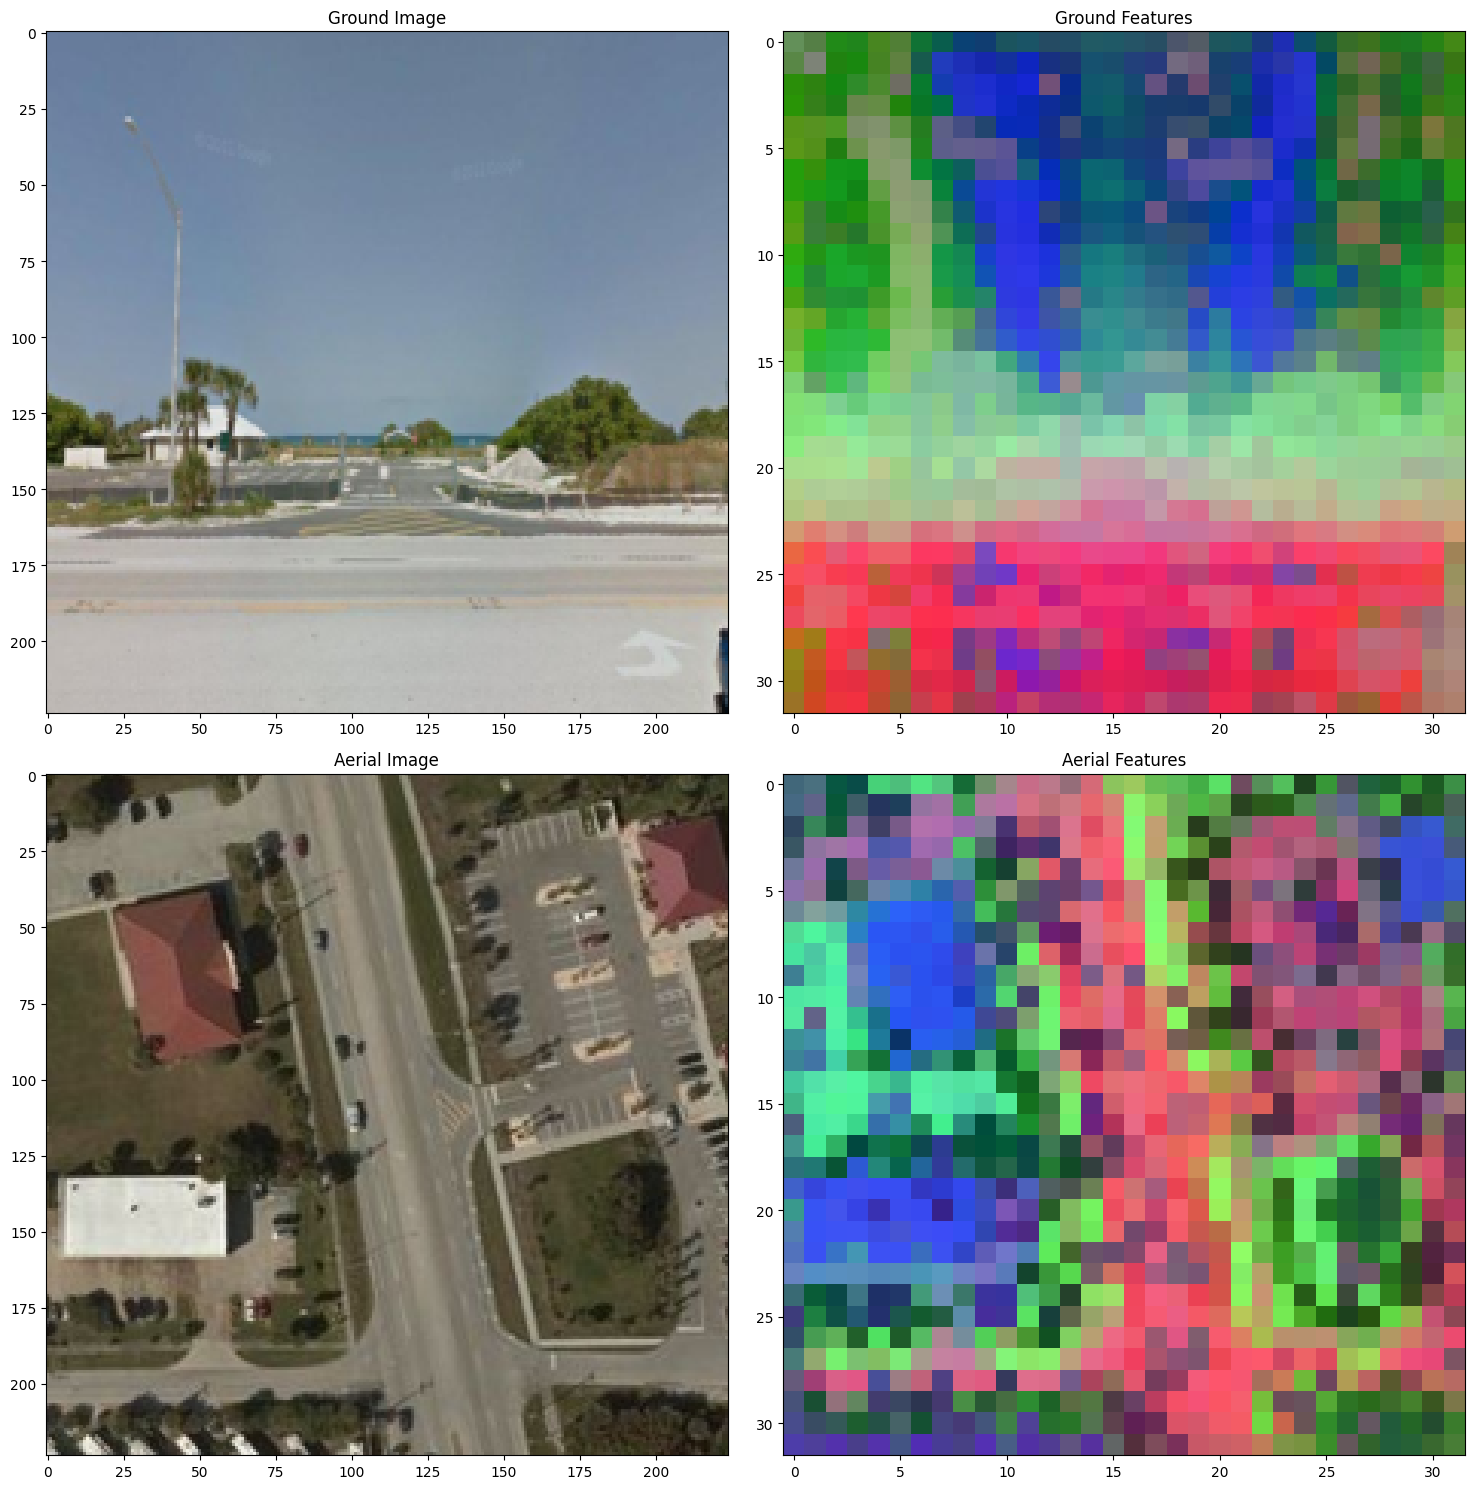

In [13]:
# Sample paired images
dataset_path = '/home/lrusso/cvusa'
train_filenames, val_filenames = sample_paired_images(dataset_path, sample_percentage=0.2, split_ratio=0.8, groundtype='cutouts')

# Settings
image_size = 224
aerial_scaling = 3
provide_paths = False

transform_ground = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop((image_size, image_size)),
    transforms.ToTensor()
])

transform_aerial = transforms.Compose([
    transforms.Resize((int(image_size * aerial_scaling), int(image_size * aerial_scaling))),
    transforms.CenterCrop((image_size, image_size)),
    transforms.ToTensor()
])

# Instantiate the dataset and dataloader
paired_dataset = PairedImagesDataset(train_filenames, transform_aerial=transform_aerial, transform_ground=transform_ground)
data_loader = DataLoader(paired_dataset, batch_size=1, shuffle=True)

# Load a single pair of images
ground_image, aerial_image = next(iter(data_loader))

if provide_paths:

    # Load images
    img1_filepath = r'/home/lrusso/projects/crossview/matching_example/asd1.jpg'
    img2_filepath = r'/home/lrusso/projects/crossview/matching_example/asd2.jpg'
    img1_filepath = r'/home/lrusso/projects/crossview/mavrec/train/aerial/scene_1_Cortex_Park_crossroads_drone_000000.PNG'
    img2_filepath = r'/home/lrusso/projects/crossview/mavrec/train/ground/scene_1_Cortex_Park_crossroads_ground_000000.PNG'

    # Read the images
    image1 = cv2.imread(img1_filepath, cv2.IMREAD_COLOR)
    image2 = cv2.imread(img2_filepath, cv2.IMREAD_COLOR)

    # Check if images are loaded properly
    if image1 is None or image2 is None:
        if image1 is None:
            print(f"Failed to load image: {img1_filepath}")
        if image2 is None:
            print(f"Failed to load image: {img2_filepath}")
        raise FileNotFoundError("One or both images were not found or cannot be read.")

    # Print the shapes of the images to verify
    print(f"image1.shape: {image1.shape if image1 is not None else 'Not Loaded'}")
    print(f"image2.shape: {image2.shape if image2 is not None else 'Not Loaded'}")

    # Convert color format
    ground_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    aerial_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

else:

    # Convert to NumPy array for processing
    ground_image = ground_image.squeeze(0).numpy().transpose(1, 2, 0) * 255
    aerial_image = aerial_image.squeeze(0).numpy().transpose(1, 2, 0) * 255

# Convert back to uint8
ground_image = ground_image.astype(np.uint8)
aerial_image = aerial_image.astype(np.uint8)

# Init Dinov2Matcher
dm = Dinov2Matcher(half_precision=False)

# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(ground_image)
features1 = dm.extract_features(image_tensor1)

image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(aerial_image)
features2 = dm.extract_features(image_tensor2)

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
ax1.imshow(ground_image)
ax1.set_title('Ground Image')
vis_image1 = dm.get_embedding_visualization(features1, grid_size1)
ax2.imshow(vis_image1)
ax2.set_title('Ground Features')

ax3.imshow(aerial_image)
ax3.set_title('Aerial Image')
vis_image2 = dm.get_embedding_visualization(features2, grid_size2)
ax4.imshow(vis_image2)
ax4.set_title('Aerial Features')

fig.tight_layout()

# More info
print("ground_image.shape:", ground_image.shape)
print("aerial_image.shape:", aerial_image.shape)
print("image_tensor1.shape:", image_tensor1.shape)
print("image_tensor2.shape:", image_tensor2.shape)
print("grid_size1:", grid_size1)
print("grid_size2:", grid_size2)
print("resize_scale1:", resize_scale1)
print("resize_scale2:", resize_scale2)

tokens1.shape (1024, 768)
token2.shape (1024, 768)
reduced_tokens.shape (2048, 3)


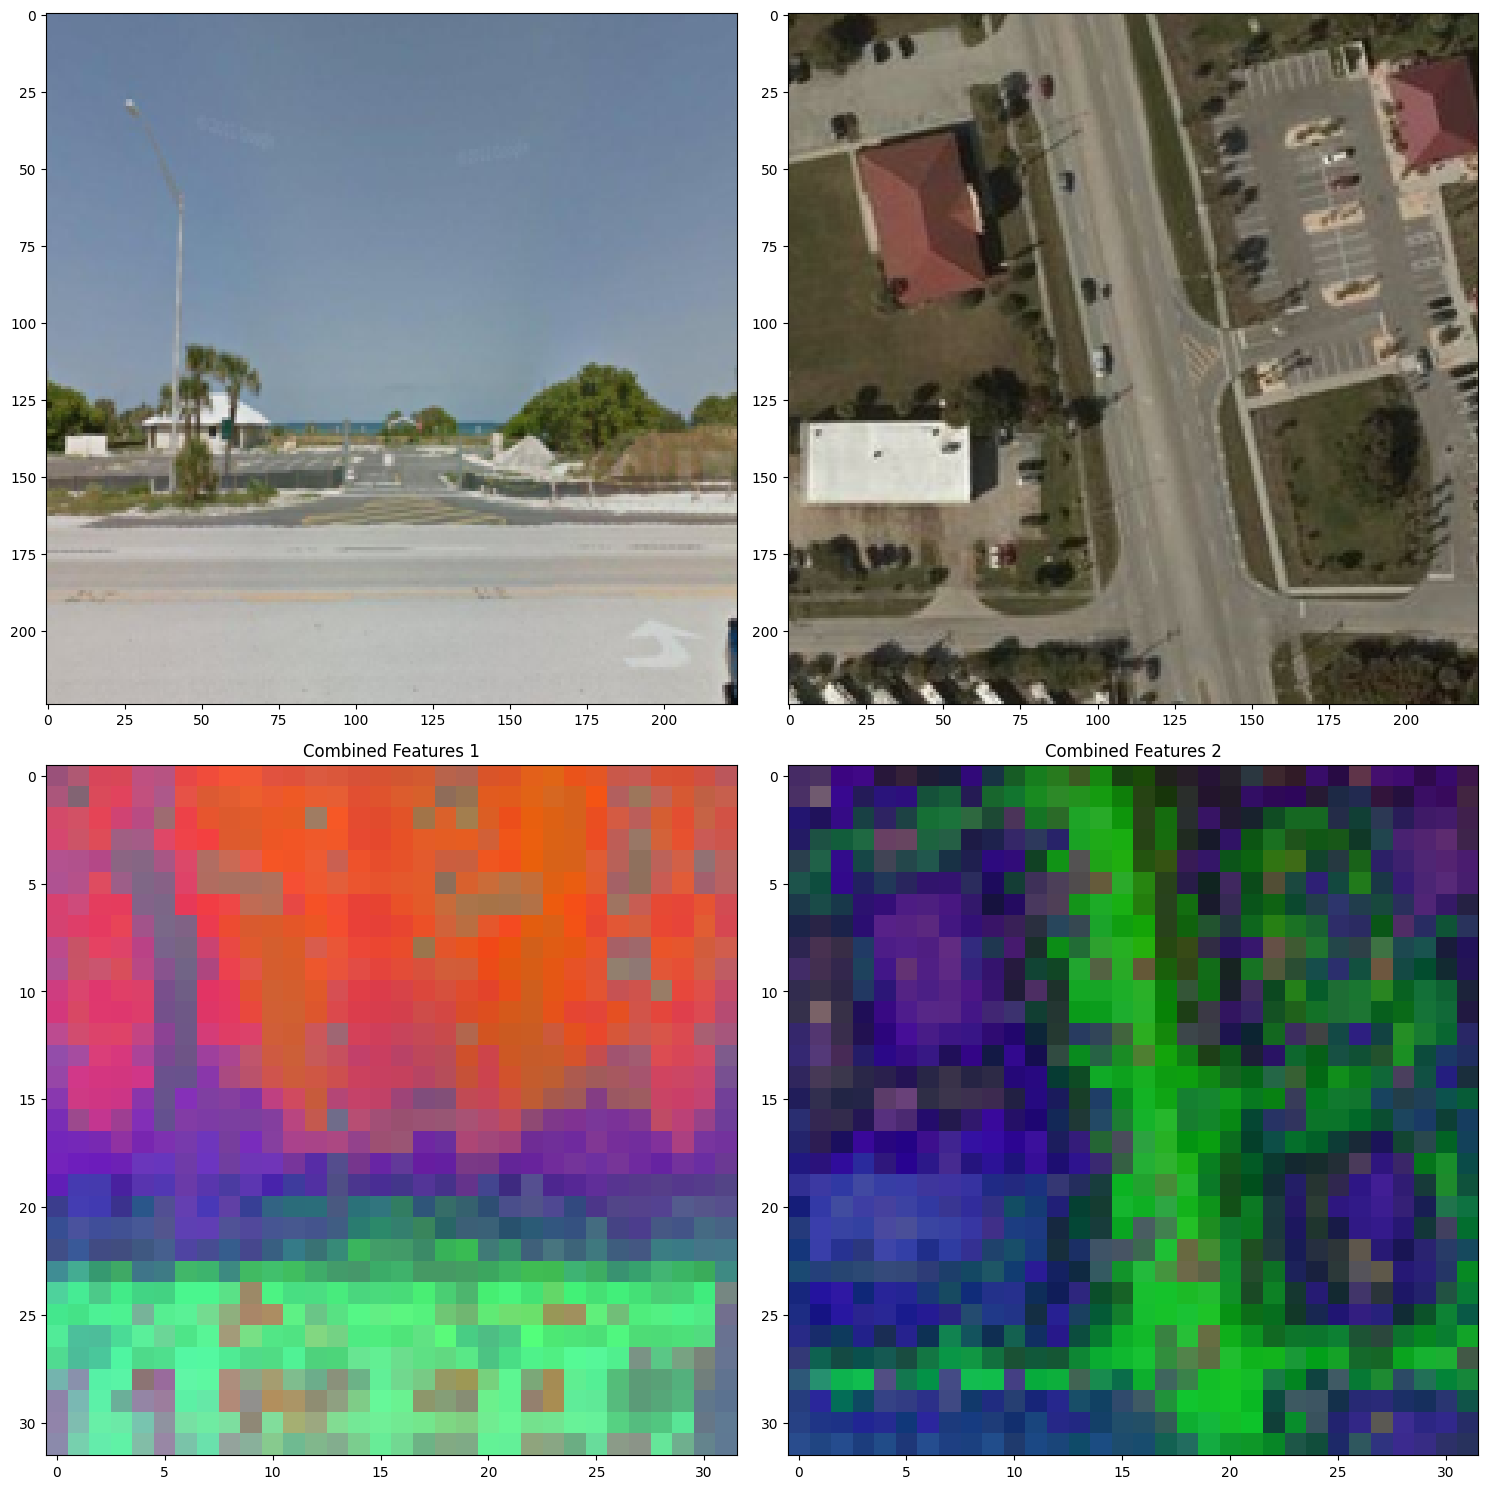

In [14]:
# Combined Visualization
fig2, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(15, 15))
vis_combined1, vis_combined2 = dm.get_combined_embedding_visualization(features1, features2, grid_size1, grid_size2)
ax5.imshow(ground_image)
ax6.imshow(aerial_image)
ax7.imshow(vis_combined1)
ax7.set_title('Combined Features 1')
ax8.imshow(vis_combined2)
ax8.set_title('Combined Features 2')
fig2.tight_layout()

normalized_features1.shape: (1024, 768)
normalized_features2.shape: (1024, 768)
Selected index from aerial features:  72


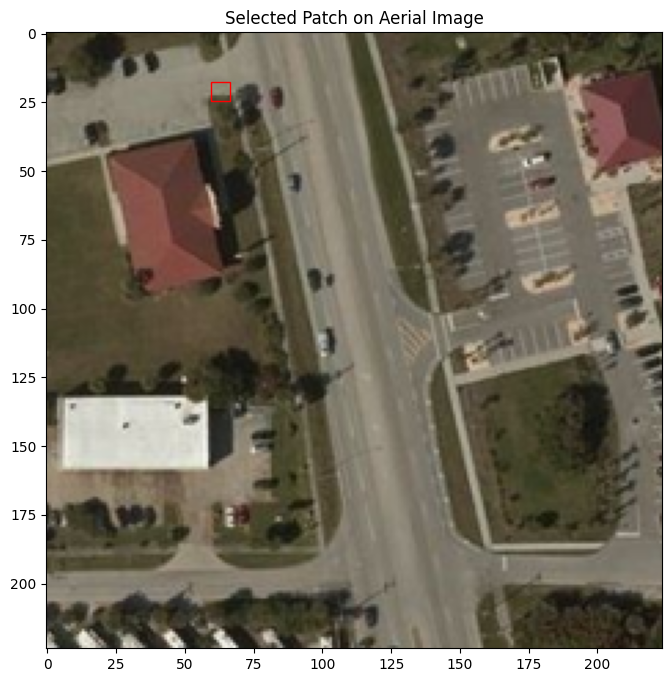

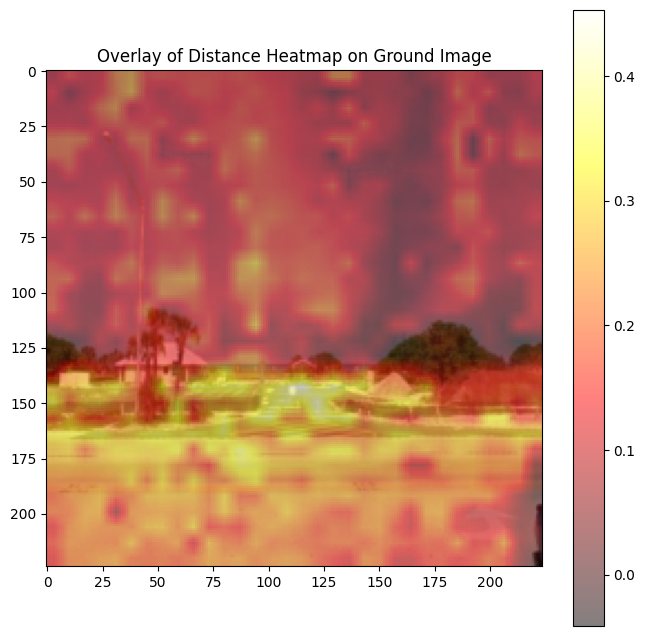

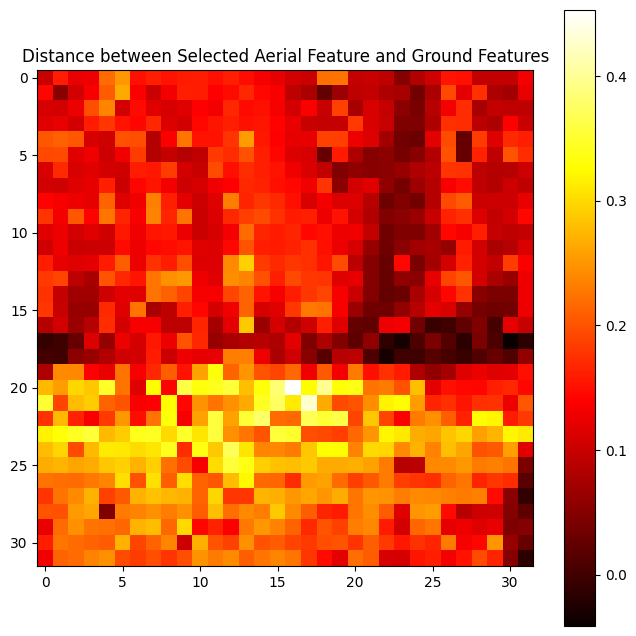

In [15]:
from sklearn.preprocessing import normalize

# Normalize the features
normalized_features1 = normalize(features1, axis=1)
normalized_features2 = normalize(features2, axis=1)
print("normalized_features1.shape:", normalized_features1.shape)
print("normalized_features2.shape:", normalized_features2.shape)

# Take one element from features2 (aerial image features)
random_index = np.random.randint(0, features2.shape[0])
selected_feature = normalized_features2[random_index]
print("Selected index from aerial features: ", random_index)

# Show which small piece of the aerial image was chosen
row_aerial, col_aerial = dm.idx_to_source_position(random_index, grid_size2, resize_scale2)
selected_patch_size = dm.model.patch_size * resize_scale2

plt.figure(figsize=(8, 8))
plt.imshow(aerial_image)
rect = plt.Rectangle((col_aerial - selected_patch_size / 2, row_aerial - selected_patch_size / 2),
                     selected_patch_size, selected_patch_size,
                     linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.title('Selected Patch on Aerial Image')
plt.show()

# Compute the distance (inner product) between this element and all elements of features1 (ground image features)
distances = np.dot(normalized_features1, selected_feature)

# Reshape into the appropriate dimensions for the ground image
reshaped_distances = distances.reshape(grid_size1)

# Resize the heatmap to fit the ground image
resized_heatmap = cv2.resize(reshaped_distances, (ground_image.shape[1], ground_image.shape[0]))

# Overlay heatmap on the ground image with variable transparency (alpha)
alpha = 0.5
plt.figure(figsize=(8, 8))
plt.imshow(ground_image)
plt.imshow(resized_heatmap, cmap='hot', interpolation='nearest', alpha=alpha)
plt.colorbar()
plt.title('Overlay of Distance Heatmap on Ground Image')
plt.show()

# Plot the reshaped distances
plt.figure(figsize=(8, 8))
plt.imshow(reshaped_distances, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Distance between Selected Aerial Feature and Ground Features')
plt.show()

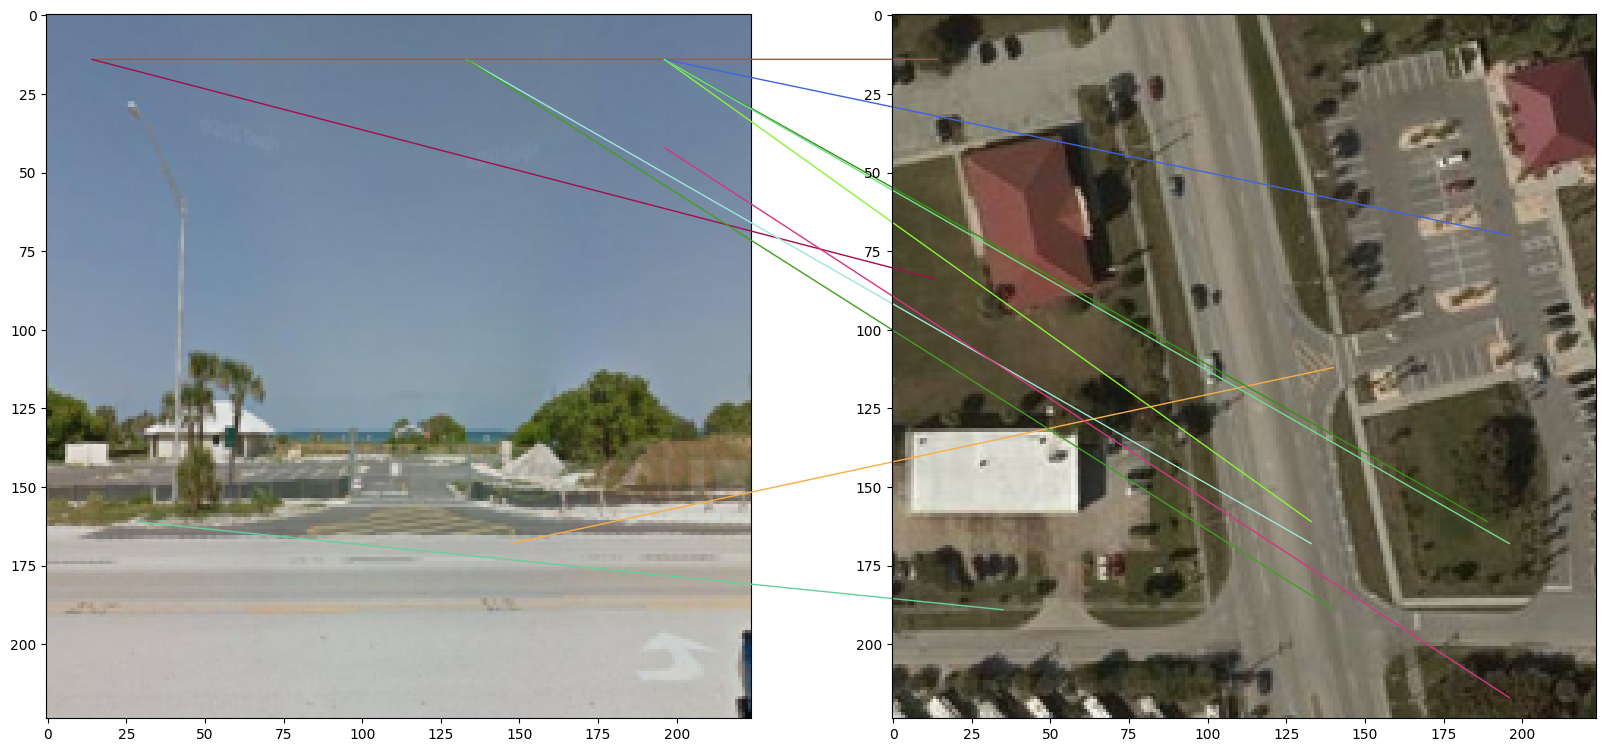

In [16]:
# Build knn using normalized features from image1, and query all normalized features from image2
knn = NearestNeighbors(n_neighbors=1)
knn.fit(normalized_features1)
distances, match2to1 = knn.kneighbors(normalized_features2)
match2to1 = np.array(match2to1)

# Get the threshold for the top 5% closest distances
threshold = np.percentile(distances, 1)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(ground_image)
ax2.imshow(aerial_image)

for idx2, (dist, idx1) in enumerate(zip(distances, match2to1)):
    if dist > threshold:  # Only plot points with distance less than the threshold
        continue

    row1, col1 = dm.idx_to_source_position(idx1[0], grid_size1, resize_scale1)
    xyA = (col1, row1)

    row2, col2 = dm.idx_to_source_position(idx2, grid_size2, resize_scale2)
    xyB = (col2, row2)

    con = ConnectionPatch(xyA=xyB, xyB=xyA, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color=np.random.rand(3,))
    ax2.add_artist(con)

plt.show()

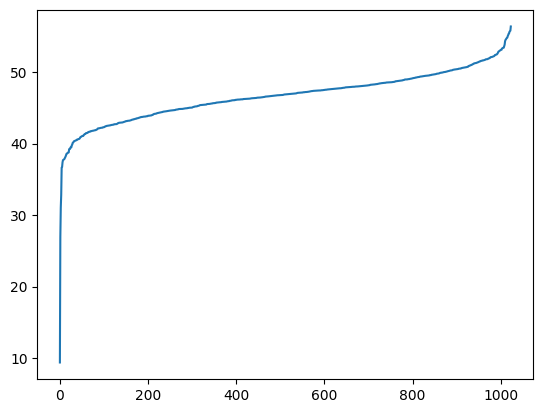

In [17]:
# Build knn using features from image1, and query all features from image2
knn = NearestNeighbors(n_neighbors=1)
knn.fit(features1)
distances, match2to1 = knn.kneighbors(features2)
match2to1 = np.array(match2to1)

plt.plot(sorted(distances))

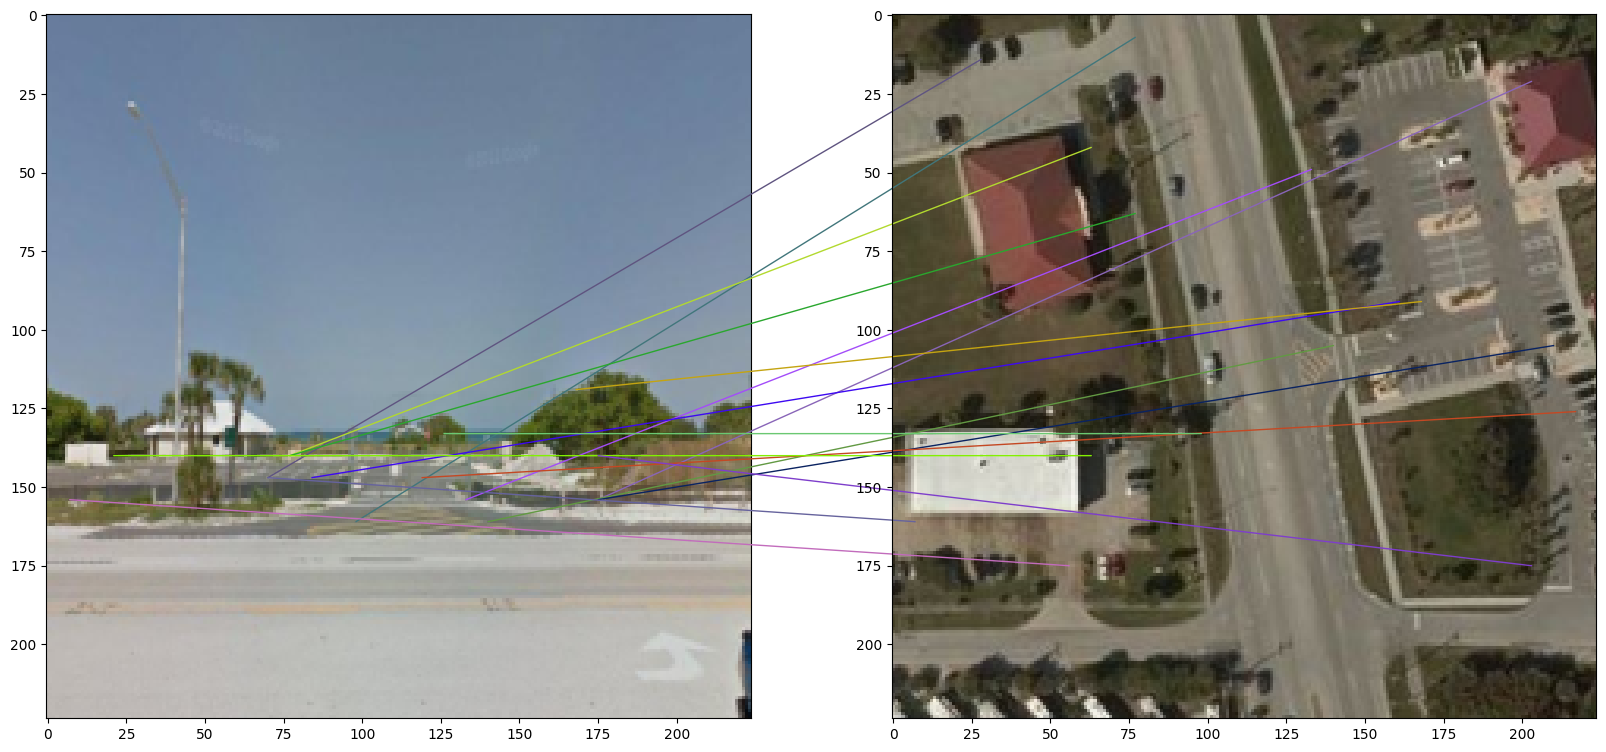

In [18]:
# This time it is random

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(ground_image)
ax2.imshow(aerial_image)

for idx2, (dist, idx1) in enumerate(zip(distances, match2to1)):
  row, col = dm.idx_to_source_position(idx1, grid_size1, resize_scale1)
  xyA = (col, row)

  row, col = dm.idx_to_source_position(idx2, grid_size2, resize_scale2)
  xyB = (col, row)

  if np.random.rand() > 0.02: continue # sparsely draw so that we can see the lines...

  con = ConnectionPatch(xyA=xyB, xyB=xyA, coordsA="data", coordsB="data",
                        axesA=ax2, axesB=ax1, color=np.random.rand(3,))
  ax2.add_artist(con)
